# Ames Housing Price Prediction

---

## 1. Problem Description

The goal of this project is to predict the sale price of residential homes using the Ames Housing dataset. This dataset contains detailed features of houses such as size, condition, neighborhood, year built, and many more. Predicting house prices is a classic supervised regression problem and can be useful for buyers, sellers, and real estate professionals to estimate market values based on property characteristics.

---

In [5]:
import sys
print(sys.executable)


/opt/homebrew/opt/python@3.11/bin/python3.11


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


---

## 2. Exploratory Data Analysis (EDA)

- The dataset contains over 80 features including numeric and categorical data.
- Some columns had substantial missing values (e.g., `Pool QC`, `Fence`, `Fireplace Qu`) which were handled by imputing `"None"` since their absence is meaningful (e.g., no pool or fence).
- Numeric features with missing data were imputed with median values to preserve distribution.
- Categorical missing values were filled with the most frequent category (mode).
- Feature engineering was performed to create:
  - **TotalSF**: total square footage combining basement, first and second floors
  - **HouseAge**: age of the house at the time of sale
  - **Remodeled**: a binary indicator if the house was remodeled
- Categorical variables were one-hot encoded to prepare for modeling.

---

In [ ]:
# Load the data
df = pd.read_csv("AmesHousing.csv")
print("Original shape:", df.shape)

Original shape: (2930, 82)


In [ ]:
# Calculate percentage of missing values per column
missing_pct = df.isnull().mean() * 100

# View missing data summary
missing_summary = missing_pct[missing_pct > 0].sort_values(ascending=False)
print("\nMissing value summary:")
print(missing_summary.head(10))

# Drop columns with > 30% missing unless they are meaningful for modeling
sparse_but_meaningful = ['Pool QC', 'Fence', 'Fireplace Qu', 'Alley', 'Misc Feature']
cols_to_drop = missing_pct[(missing_pct > 30) & (~missing_pct.index.isin(sparse_but_meaningful))].index
df.drop(columns=cols_to_drop, inplace=True)

# Fill NA in sparse-but-meaningful features with 'None'
for col in sparse_but_meaningful:
    if col in df.columns:
        df[col] = df[col].fillna("None")

# Separate remaining numeric and categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

# Impute missing numerical values with median
for col in num_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# Impute missing categorical values with mode
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])


Missing value summary:
Series([], dtype: float64)


In [ ]:
# Total square footage: combine 1st floor, 2nd floor, and total basement
df["TotalSF"] = df["1st Flr SF"] + df["2nd Flr SF"] + df["Total Bsmt SF"]

# Age of house at sale time
df["HouseAge"] = df["Yr Sold"] - df["Year Built"]

# Whether house was remodeled
df["Remodeled"] = (df["Year Remod/Add"] != df["Year Built"]).astype(int)

# Drop PID or Order if present
df.drop(columns=[col for col in ["PID", "Order"] if col in df.columns], inplace=True)


In [ ]:
# One-hot encode all categorical variables
df = pd.get_dummies(df, drop_first=True)


---

## 3. Modeling & Training

We trained three supervised regression models to predict `SalePrice`:

- **Linear Regression:** A simple linear approach assuming a linear relationship between features and price.
- **Random Forest Regressor:** An ensemble of decision trees that reduces variance and captures nonlinear patterns.
- **Gradient Boosting Regressor:** An ensemble boosting method that iteratively improves predictions and often yields strong performance on structured data.

Data was split into 80% training and 20% testing sets. Linear regression features were scaled using standardization, while tree-based models used raw features.

---

In [ ]:
# Separate target variable
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Linear Regression Results:
  RMSE: 29187.63
  R^2:  0.8937



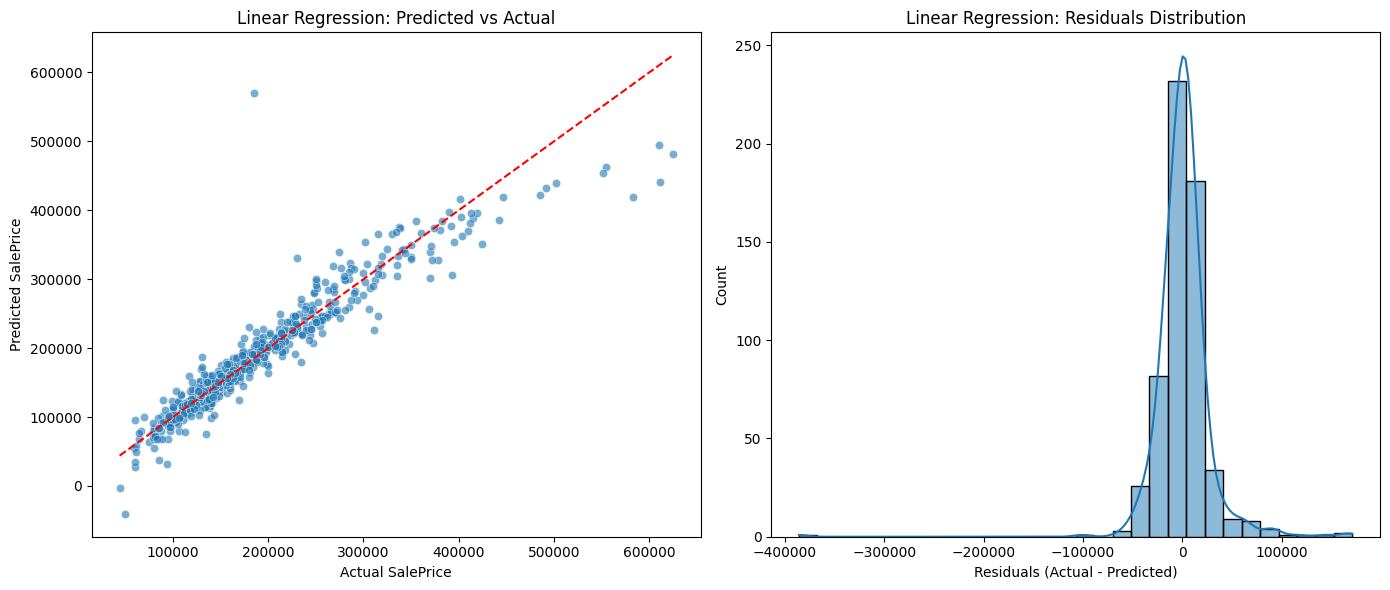

Random Forest Results:
  RMSE: 25138.43
  R^2:  0.9212



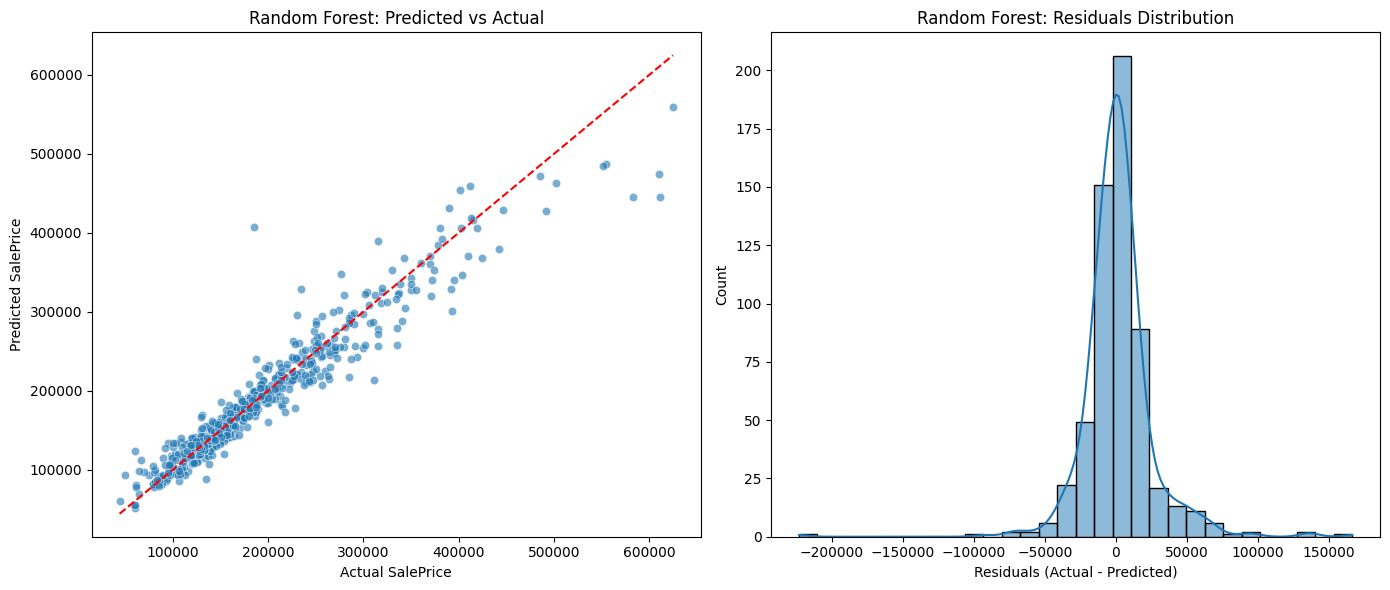

Gradient Boosting (sklearn) Results:
  RMSE: 24189.49
  R^2:  0.9270



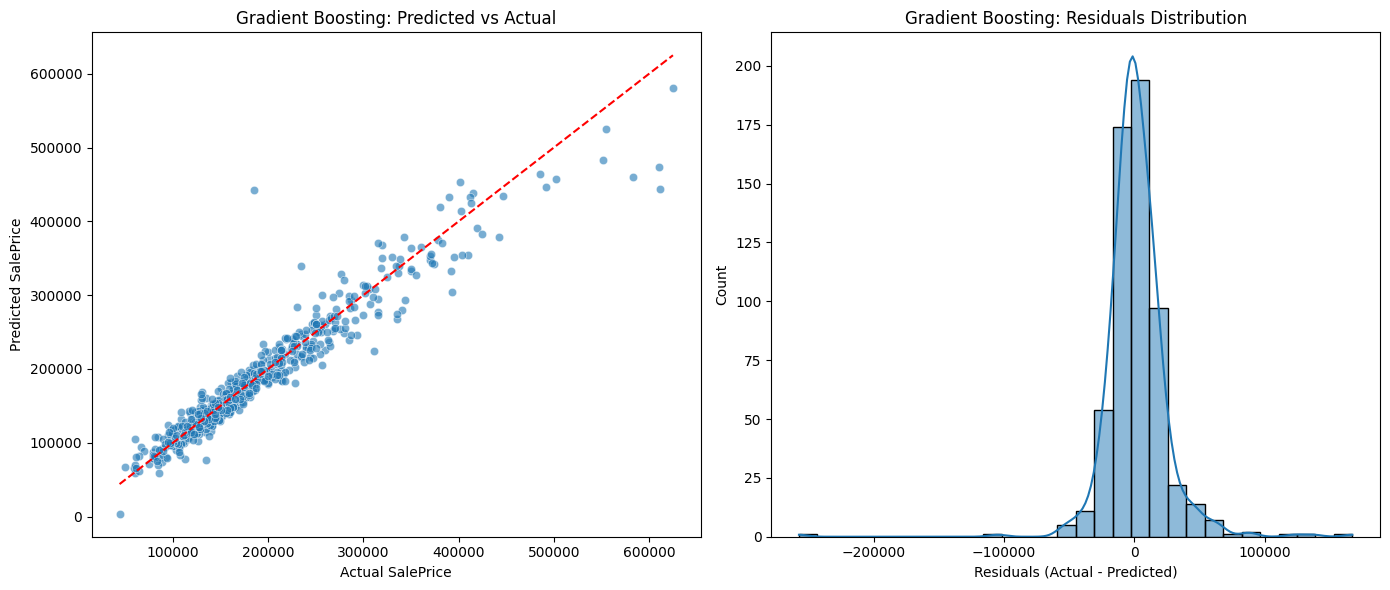

In [37]:
def evaluate_model(name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Results:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R^2:  {r2:.4f}\n")

def plot_results(y_true, y_pred, model_name):
    residuals = y_true - y_pred

    plt.figure(figsize=(14,6))

    plt.subplot(1,2,1)
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual SalePrice")
    plt.ylabel("Predicted SalePrice")
    plt.title(f"{model_name}: Predicted vs Actual")

    plt.subplot(1,2,2)
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel("Residuals (Actual - Predicted)")
    plt.title(f"{model_name}: Residuals Distribution")

    plt.tight_layout()
    plt.show()

# --- Linear Regression ---
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
evaluate_model("Linear Regression", y_test, y_pred_lr)
plot_results(y_test, y_pred_lr, "Linear Regression")

# --- Random Forest ---
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
evaluate_model("Random Forest", y_test, y_pred_rf)
plot_results(y_test, y_pred_rf, "Random Forest")

# --- Gradient Boosting (sklearn) ---
gbr = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
evaluate_model("Gradient Boosting (sklearn)", y_test, y_pred_gbr)
plot_results(y_test, y_pred_gbr, "Gradient Boosting")

---

## 4. Results

| Model                 | RMSE       | R² Score |
|-----------------------|------------|----------|
| Linear Regression     | 29,187.63  | 0.8937   |
| Random Forest         | 25,138.43  | 0.9212   |
| Gradient Boosting     | 24,189.49  | 0.9270   |

- Lower RMSE indicates better average prediction accuracy.
- Higher R² indicates the model explains more variance in house prices.

Visualizations show predicted vs actual prices clustered closely along the identity line, and residuals are roughly centered around zero, indicating unbiased predictions.

---

## 5. Discussion and Conclusion

- The **Gradient Boosting Regressor** performed best in both RMSE and R², showing its strength in capturing complex nonlinear relationships in housing data.
- **Random Forest** also performed very well, better than Linear Regression, indicating nonlinearities and interactions between features.
- **Linear Regression** still explained approximately 89% of the variance, which is strong, but its higher RMSE shows it lacks flexibility compared to tree ensembles.
- Feature importance analysis from tree models highlighted key drivers of house price such as overall quality, neighborhood, and total square footage.
- Missing data treatment and thoughtful feature engineering contributed to model performance.
- Future work could include hyperparameter tuning, cross-validation, or incorporating more domain knowledge features.
- This project demonstrates that ensemble methods provide powerful tools for real estate price prediction.
